In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
data = pd.read_csv('/content/bank-additional-full.csv')

In [3]:
data = data.drop_duplicates()
data.shape

(41176, 21)

In [4]:
data = data[data['job'] != 'unknown']
data = data[data['marital'] != 'unknown']
data = data[data['education'] != 'unknown']
data = data[data['default'] != 'unknown']
data = data[data['housing'] != 'unknown']
data = data[data['loan'] != 'unknown']
data = data[data['contact'] != 'unknown']
data = data[data['month'] != 'unknown']
data = data[data['day_of_week'] != 'unknown']
data = data[data['poutcome'] != 'unknown']

In [5]:
data['job'] = [0 if elem=='admin.' else 1 if elem=='blue-collar' else 2 if elem=='technician' else 3 if elem=='services' else 4 if elem=='management' else 5 if elem=='retired' else 6 if elem=='entrepreneur' else 7 if elem=='self-employed' else 8 if elem=='housemaid' else 9 if elem=='student' else 10 if elem=='unemployed' else 11 for elem in data['job']]
data['marital'] = [0 if elem=='married.' else 1 if elem=='single' else 2 if elem=='divorce' else 3 for elem in data['marital']]
data['education'] = [1 if elem=='university.degree' else 2 if elem=='high.school' else 3 if elem=='basic.9y' else 4 if elem=='professional.course' else 5 if elem=='basic.4y' else 6 if elem=='basic.6y' else 7 for elem in data['education']]
data['default'] = [1 if elem=='no' else 2 if elem=='yes' else 3 for elem in data['default']]
data['housing'] = [1 if elem=='no' else 2 if elem=='yes' else 3 for elem in data['housing']]
data['loan'] = [1 if elem=='no' else 2 if elem=='yes' else 3 for elem in data['loan']]
data['contact'] = [1 if elem=='cellular' else 2 for elem in data['contact']]
data['month'] = [0.5 if elem=='may' else 0.7 if elem=='jul' else 0.8 if elem=='aug' else 0.6 if elem=='jun' else 0.11 if elem=='nov' else 0.4 if elem=='apr' else 0.10 if elem=='oct' else 0.9 if elem=='sep' else 0.3 if elem=='mar' else 0.12 for elem in data['month']]
data['day_of_week'] = [0.10 if elem=='mon' else 0.40 if elem=='thu' else 0.30 if elem=='wed' else 0.20 if elem=='tue' else 0.50 for elem in data['day_of_week']]
data['poutcome'] = [1 if elem=='nonexistent' else 2 if elem=='failure' else 3 for elem in data['poutcome']]

In [6]:
data['y'] = [1 if elem=='no' else 0 for elem in data['y']]

In [7]:
data_no = data.loc[data['y']==1]
data_yes = data.loc[data['y']==0]

In [8]:
data_no_train = data_no[10000:25000]
data_no_test = data_no[:4000]
data_yes_train = data_yes[:3000]
data_yes_test = data_yes[3000:]

In [9]:
train = pd.DataFrame(pd.concat([data_no_train,data_yes_train]))
test = pd.DataFrame(pd.concat([data_no_test,data_yes_test]))

In [10]:
train = train.reset_index(drop = True)   #reset index for the train data
test = test.reset_index(drop = True)     #reset index for the test data

In [11]:
y_train = train['y']
y_test = test['y']

In [12]:
train = train.drop(['y'],axis=1)
test = test.drop(['y'],axis=1)

In [13]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [14]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

## **Expectation Step**

In [15]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_bl(row,thetas):
  log_bl = []
  for theta in thetas:
    alpha_K, alpha, beta = theta[:len(theta)-2], theta[len(theta)-2], theta[len(theta)-1]
    c = gammaln(np.sum(alpha_K)) + gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta)
    q1 = (alpha-np.sum(alpha_K))*np.log(np.mean(row)) + (beta-1)*np.log(np.abs(1-np.mean(row)))
    q2 = np.sum(((alpha_K)-1)*np.log(row)) - np.sum(np.log(alpha_K))
    log_bl.append(c+q1+q2)
  return log_bl

In [16]:
def expectation_step(data, thetas, P,number_of_clusters):
    Z = np.zeros((len(data), number_of_clusters))

    for i, row in enumerate(data):
        log_posteriors = np.log(P) + log_bl(row, thetas)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        Z[i] = posteriors / np.sum(posteriors)
    return Z

## **Maximization Step** ##

In [17]:
def update_P(Z):
  return np.mean(Z,axis=0)

In [18]:
def normalize_theta(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [19]:
def calcul_inv_hess_vect(data,theta,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-15),None)
  inv_hess_vect_matrices = []
  for j in range(M):
    theta_j = theta[j]
    vect_alpha_j = theta_j[:len(theta_j)-2]
    S = np.diag([-1/(float(polygamma(1,vect_alpha_j[m]))*N*Z_mean[j]) for m in range(K)])
    a_T = np.array([[-1/(float(polygamma(1,vect_alpha_j[m]))*N*Z_mean[j]) for m in range(K)]])
    gamma_et = float(polygamma(1,np.sum(vect_alpha_j)))*N*Z_mean[j] / (1+float(polygamma(1,np.sum(vect_alpha_j)))*N*Z_mean[j]*np.sum([-1/(np.sum(vect_alpha_j)*N*Z_mean[j]) for m in range(K)]))
    H_inv = S + gamma_et*np.dot(a_T.T,a_T)
    inv_hess_vect_matrices.append(H_inv)
  return inv_hess_vect_matrices

In [20]:
def calcul_inv_hess_non_vect(data,theta,Z,number_of_clusters):
  M, N = number_of_clusters, data.shape[0]
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-6),None)
  inv_hess_non_vect_matrices = []
  for j in range(M):
    theta_j = theta[j]
    H_j = np.zeros((2,2))
    alpha_j, beta_j = theta_j[len(theta_j)-2], theta_j[len(theta_j)-1]
    H_j[0][0] = N*Z_mean[j]*(float(polygamma(1,alpha_j+beta_j)) - float(polygamma(1,alpha_j)))
    H_j[1][1] = N*Z_mean[j]*(float(polygamma(1,alpha_j+beta_j)) - float(polygamma(1,beta_j)))
    H_j[0][1] = H_j[1][0] = N*Z_mean[j]*float(polygamma(1,alpha_j+beta_j))
    inv_H_j = np.linalg.inv(H_j)
    inv_hess_non_vect_matrices.append(inv_H_j)
  return inv_hess_non_vect_matrices

In [21]:
def derivative(data,theta_old,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.mean(Z,axis=0)
  der_param = []
  for j in range(M):
    der_vect_alpha_j = np.zeros(K)
    theta_old_j = theta_old[j]
    vect_alpha_old_j, alpha_old_j, beta_old_j = theta_old_j[:len(theta_old_j)-2], theta_old_j[len(theta_old_j)-2], theta_old_j[len(theta_old_j)-1]
    for s in range(K):
      der_vect_alpha_j[s] =N*Z_mean[j]*(psi(np.sum(vect_alpha_old_j)) - psi(vect_alpha_old_j[s])) - np.sum( Z[:,j]*np.log(data[:,s]) )
    der_alpha_j = N*Z_mean[j]*(psi(alpha_old_j+beta_old_j)-psi(alpha_old_j)) + np.sum([Z[i][j]*np.log(np.mean(data[i])) for i in range(N)])
    der_beta_j = N*Z_mean[j]*(psi(alpha_old_j+beta_old_j)-psi(alpha_old_j)) + np.sum([Z[i][j]*np.log(1-np.mean(data[i])) for i in range(N)])
    der_theta_j = np.concatenate((der_vect_alpha_j, der_alpha_j,der_beta_j), axis=None)
    der_param.append(der_theta_j)
  return der_param

In [22]:
from keras.utils.generic_utils import to_list
def update_theta(data,theta_old,Z,number_of_clusters):
  M = number_of_clusters
  H_non_vect, H_vect = calcul_inv_hess_non_vect(data,theta_old,Z,number_of_clusters), calcul_inv_hess_vect(data,theta_old,Z,number_of_clusters)
  der_param = derivative(data,theta_old,Z,number_of_clusters)
  theta_new = []
  for j in range(M):
    (theta_old_j,der_param_j,H_non_vect_j,H_vect_j) = (theta_old[j],der_param[j],H_non_vect[j],H_vect[j])
    (vect_alpha_old_j, alpha_beta_old_j,der_vect_alpha_old_j, der_alpha_beta_old_j) = (theta_old_j[:len(theta_old_j)-2], theta_old_j[len(theta_old_j)-2:],der_param_j[:len(der_param_j)-2], der_param_j[len(der_param_j)-2:])
    vect_alpha_new_j = vect_alpha_old_j - np.dot(H_vect_j,der_vect_alpha_old_j)
    alpha_beta_new_j = alpha_beta_old_j - np.dot(H_non_vect_j,der_alpha_beta_old_j)
    theta_new.append(np.clip(normalize_theta(np.concatenate((vect_alpha_new_j,alpha_beta_new_j), axis=None),5.5,10),10**(-15),None))
  return theta_new

In [23]:
#Sometimes we need to switch the positions of the elements of the parameters vector to solve the label switching problem
theta_zero = [np.array([6.10963329, 6.84227047, 8.0648421 , 8.15892743, 8.08446362,
       8.43940369, 8.43446472, 7.44138296, 9.53445968, 7.15402842,
       7.46139216, 9.5136551 , 9.12787295, 8.66749863, 5.95102099,
       9.63767176, 8.71408585, 9.99481153, 6.17251737, 9.40656726,
       6.23121821, 8.27001804]), np.array([6.05718992, 9.31603703, 9.13293531, 8.06095332, 7.33232484,
       5.81125148, 8.63842948, 7.54094207, 8.7492502 , 9.39872047,
       9.88984677, 9.35111504, 5.55271338, 7.11990129, 8.78495753,
       6.27233355, 7.84466473, 5.74452095, 6.39998436, 5.58334808,
       9.07163967, 6.5076611 ])]

In [24]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

x_train_task = train
x_test_task = test

#EM Algorithm
M = 2
P = [0.15, 0.85]
theta_old = theta_zero
max_iter = 3
for iteration in range(max_iter):
  Z = expectation_step(x_train_task,theta_old,P,M)
  theta_new = update_theta(x_train_task,theta_old,Z,M)
  P = np.clip(update_P(Z),10**(-15),None)
  theta_old = theta_new

In [25]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

predictions_bin = []
for row in x_test_task:
      log_posteriors = np.exp(np.log(P)+log_bl(row,theta_new))
      predicted_label = np.argmax(log_posteriors)
      predictions_bin.append(predicted_label)
predictions_bin = np.asarray(predictions_bin)
labels = np.array(y_test).flatten()
f1 = f1_score(labels, predictions_bin)
precision = precision_score(labels, predictions_bin)
recall = recall_score(labels, predictions_bin)
acc = accuracy_score(labels, predictions_bin)

print("Accuracy:", acc)
print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9250720461095101
F1 score: 0.9564801530368244
Precision: 0.916590284142988
Recall: 1.0


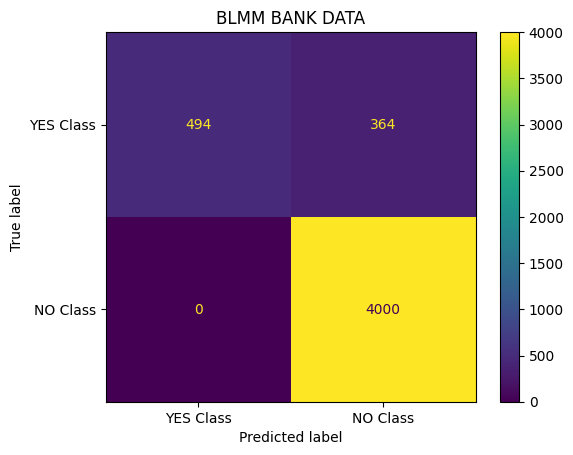

In [26]:
cm = confusion_matrix(labels, predictions_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['YES Class', 'NO Class'])
cm_display.plot()
cm_display.ax_.set_title('BLMM BANK DATA')
plt.show()